# Related Work

In this notebook we compare rnalib to related work, namely to
* [pybedtools](https://daler.github.io/pybedtools/index.html), a python library wrapping the popular BEDTools utilities and
* [bioframe](https://bioframe.readthedocs.io/), a genomics library based on pandas dataframes.

Pybedtools enables various set theory operations on genomic dataset (such as intersect, merge, count, complement,
and shuffle) in various data formats (BAM, BED, GFF/GTF and VCF) and also supports data streaming.
Bioframe is built on top of pandas dataframes and provides a flexible and scalable API for working with genomic
intervals. In this regard, the functionality of both libraries overlaps partially with rnalib's genomic iterators
that are built on top of the pysam implementation.

The three compared libraries implement different approaches, each having with pros and cons in different access scenarios:
* Bioframe leverages the efficient implementation of pandas dataframes but needs to load the whole dataset into
memory before it can be processed.
* Pybedtools is built on the efficient implementation of BEDtools and shows good performance in pure iteration tasks 
but provides no random access features which means that some filtering tasks require preprocessing the whole dataset 
when just a small subset is needed.
* rnalib is built on the efficient implementation of pysam and leverages indexing data structures of genomics
datasets (e.g., BAM or tabix indices) for efficient random access

In the [first section](#Performance-comparison) of this notebook, we compare the performance of the three libraries in different scenarios in order to highlighttheir respective strengths and weaknesses. In a summary, rnalib's iterators (based on the respective pysam implementation) are clearly outperformed by other implementations if whole datasets are considered/iterated but are much faster when only subregions are considered due to its efficient random access features.

Overall, however, please note that iterating over large interval sets is generally considered slow and is often not needed. In many cases you can use list comprehension, vectorisation or mechanisms such as pandas apply() or pybedtools each(). Nevertheless, there are scenarios in which we consider iteration useful, e.g., if you need to access to contextual data (e.g., annotation results from previous data rows) or if you need (fine-grained) access to multiple synchronized datasets in parallel. Performance drawbacks of iteration approaches are also diminished when integrating multiple iterators in parallel. 

Another perspective is that during a design/development phase of novel algorithms, code readability and reproducibility are more important than pure 
code performance. rnalib enables developers to quickly apply their code to either whole datasets or particular (complex) sub-regions. We also hope that rnalib's approach can reduce potential error sources such as the ones discussed in the 'pitfalls' section. 

Overall, however, we envision that user's would like to mix and match these three and other genomics libraries based on the actual use-case and performance requirements. Users could, for example, use BEDtools set operations on some input file, store these files and then run a rnalib analysis on them. Or they could use rnalib to instantiate an annotated transcriptome, convert it to a pandas dataframe and use bioframe for further analysis.
rnalib implements respective interfaces for this purpose (e.g., a `PybedtoolsIterator` that wraps a pybedtools BedTool while providing the same interface (e.g., region filtering, stats  output) as other rnalib iterators or a `to_dataframe()` method for converting an (annotated) transcriptome to a bioframe-compatible pandas dataframe).

In the [second section](#Potential-pitfalls) of this notebook, we demonstrate some potential pitfalls of pybedtools and bioframe and discuss rnalib's strategies to avoid those.



In [10]:
# set path and load rnalib
import os, pathlib, platform
import biotite.sequence as seq
from Bio.Align import PairwiseAligner
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import pysam
import numpy as np
import pprint
import pybedtools 
import bioframe
import tempfile
import pytest
import dataclasses
import random

# load rnalib
import rnalib as rna
from rnalib import gi, SEP, display_textarea
plt.rcParams["figure.figsize"] = (20,3)

display(f"Running rnalib {rna.__version__} on python {platform.python_version()}")

'Running rnalib 1.0.0 on python 3.10.4'

## Test datasets

This notebook as well as rnalib's testing suite use various test resources (genomics data files and indexing structures) that can be created by 
running the rnalib `rnalib_create_testdata` script or by calling the `testdata.create_testdata()` method. There are two seperate resource sets:

* test_resources: small test datasets that are used by rnalib's test suite
* large_test_resources: larger test files that are needed to demonstrate rnalib under realistic conditions. 

Rnalib knows about the test data directory via the package-global __RNALIB_TESTDATA__ variable. This variable can either be set via the "RNALIB_TESTDATA" environment variable or by monkeypatching (rna.__RNALIB_TESTDATA__ = <mydir>) as shown below. Once this is done, test data resources can be accessed via 
`get_resource(<resource_id>)`. Rnalib will recreate these resources only if they are not found in the provided output folder.


In [2]:
rna.__RNALIB_TESTDATA__ = "rnalib_testdata/"

if not os.path.isdir(rna.__RNALIB_TESTDATA__):
    os.mkdir(rna.__RNALIB_TESTDATA__)
    display("Creating testdata at {rna.__RNALIB_TESTDATA__ }")
    rna.testdata.create_testdata(rna.__RNALIB_TESTDATA__, 
                                 rna.testdata.large_test_resources)
else:
    display(f"Testdata at {rna.__RNALIB_TESTDATA__}")
    rna.print_dir_tree(rna.__RNALIB_TESTDATA__)

'Testdata at rnalib_testdata/'

├── bigfiles
│   ├── grch38_chr20.fa.gz.gzi
│   ├── chess3.0.1.gtf.gz
│   ├── gencode_39.gff3.gz
│   ├── hgnc_complete_set.txt
│   ├── gencode_39.gff3.gz.tbi
│   ├── grch38_chr20.fa.gz
│   ├── GRCh38.k24.umap.bedgraph.gz
│   ├── grch38_chr20.fa.gz.fai
│   ├── chess3.0.1.gtf.gz.tbi
│   └── GRCh38.k24.umap.bedgraph.gz.tbi
├── bed
│   ├── test_bed12.bed.gz.tbi
│   ├── test_bed12.bed.gz
│   ├── test.bed.gz
│   ├── test.bedgraph.gz
│   ├── pybedtools_snps.bed.gz
│   ├── test_nist.b37_chr20_100kbp_at_10mb.bed
│   ├── dmel_randomvalues.bedgraph.gz
│   ├── GRCh38.k24.umap.ACTB_ex1+2.bedgraph.gz
│   ├── dmel_randomvalues.bedgraph.gz.tbi
│   ├── test.bedgraph.gz.tbi
│   └── ...
├── div
│   └── hgnc_complete_set.head.txt.gz
├── bam
│   ├── NA12878_S1.chr20.10_10p1mb.bam
│   ├── mapt.NA12156.altex.small.bam
│   ├── NA12878_S1.chr20.10_10p1mb.bam.bai
│   ├── mapt.NA12156.altex.small.bam.bai
│   ├── rogue_read.bam.bai
│   ├── rogue_read.bam
│   ├── small.ACTB+SOX2.bam.bai
│   ├── small_example.bam
│

## Supported Data Formats

The following table provides an overview of some popular genomics datasets that are supported
by the compared libraries:

| format | pybedtools | bioframe | rnalib |
|--------|------------|----------|----------|
| TSV    | +          | +        | +        |
| BED    | +          | +        | +        |
| GFF    | +          | +        | +        |
| GTF    | +          | +        | +        |
| VCF    | +          | +        | +        |
| BAM    | +          | +        | +        |
| BigBed | +          | +        | -        |
| BigWig | -          | +        | -        |
| pairix | -          | +        | -        |
| FASTA  | -          | +        | +        |
| FASTQ  | -          | -        | +        |
| FAST5  | -          | -        | /       |

## Performance comparison
In this section we compare iteration speed for various iterators in different scenarios and plot the results.
Note that many factors are influencing these benchmarks (such as I/O speed, memory consumption, file composition, etc.) so be careful when drawing conclusions.

Due to the efficient implementation of BEDtools, pybedtools is considerably faster than the corresponding rnalib iterators when simply iterating large datasets. 




While pybedtools is considerably faster than the corresponding 'native' rnalib iterators, it is also a bit 'unsafer' to use them as demonstrated below. Overall, however, we envision that user's would like to mix and match pybedtools and rnalib based on the actual use-case and performance requirements. Users could, for example, use BEDtools set operations on some input file, store these files and then run a rnalib analysis on them.

To facilitate seamless workflows that integrate both libraries, we also implemented a `PybedtoolsIterator` that wraps a pybedtools BedTool while providing the same interface (e.g., region filtering, stats  output) as other rnalib iterators. Below we compare the performance of rnalib and pybedtools iterators on various tasks. 


### Calculate average feature lengths
In this example, we compare different ways to calculate the average feature length in a medium-sized bed file (from the pybedtools testdata repository).
- rnalib's BedIterator is a bit slower than pybedtools which relies on the performant bedtools implementation for iterating the full bed file
- The bioframe approach is fastest for this task as it first loads the whole dataset into a pandas dataframe that then allows very efficient calculation of mean feature lengths

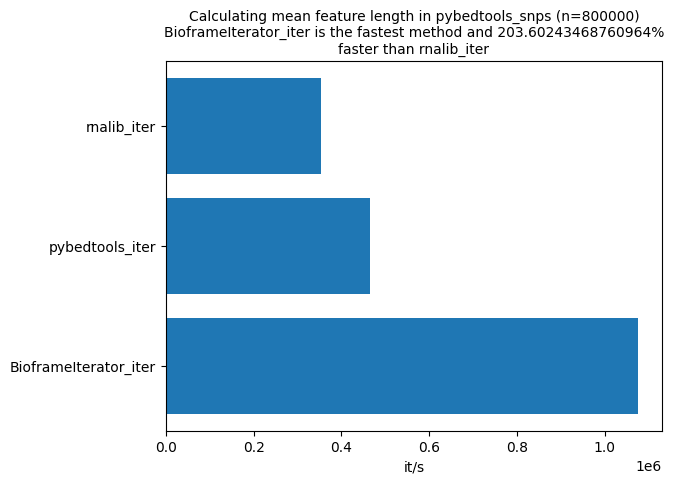

In [11]:
dataset='pybedtools_snps'
bed_file = rna.get_resource(dataset)
times, data=Counter(),Counter()
# rnalib BED iterator.
with rna.Timer(times, 'rnalib_iter') as timer:
    data[timer.name] = []
    with rna.BedIterator(bed_file) as it:
        data[timer.name]=np.mean([len(loc) for loc,_ in it])
        stats=it.stats
# pybedtools 
with rna.Timer(times, 'pybedtools_iter') as timer:
    data[timer.name] = np.mean([x.end-x.start for x in pybedtools.BedTool(bed_file)])
# bioframe
with rna.Timer(times, 'BioframeIterator_iter') as timer:
    with rna.BioframeIterator(bed_file) as it:
        it.df['len']=it.df['end']-it.df['start']
        data[timer.name] = it.df['len'].mean()

    
# assert that results match
assert len({y for y in data.values()})==1, f"Error in some computation: {data}"

n = stats[('yielded_items', None)]
rna.plot_times(f"Calculating mean feature length in {dataset} (n={n})",
           times, n=n,
           reference_method='rnalib_iter')

### Grouped aggregation
Here we test grouped aggregation of some property using random datasets. First, we create a data frame with random intervals and random values between [0; 1000] and store it as bgzipped+tabixed bedgraph file. Then we test different methods for calculating a chromosome-grouped mean score. 

- For pybedtools, we intersect the file per chromosome, store the values in a numpy array and calculate the mean
- In a second approach, we iterate the whole file and sum and count values in a per-chromosome dict. We then calculate the mean from these values.
- For bioframe, we use the rnalib BioframeIterator class just for loading the dataframe and then group/aggregate directly with pandas functionality
- We use rnalib's BedGraphIterator for iterating the values per chromosome, store them in a numpy array and calculate the mean

Results:
- Bioframe is the fastest option for this task due to the effienct pandas data grouping/aggregation functionality.
- Pybedtools iteration is second fastest
- rnalib's BedGraphIterator iterator comes out third as per-chromosome grouping is more efficiently handled than intersection in pybedtools.
- Pybedtools intersection per chromosome is the slowest approach in this scenario

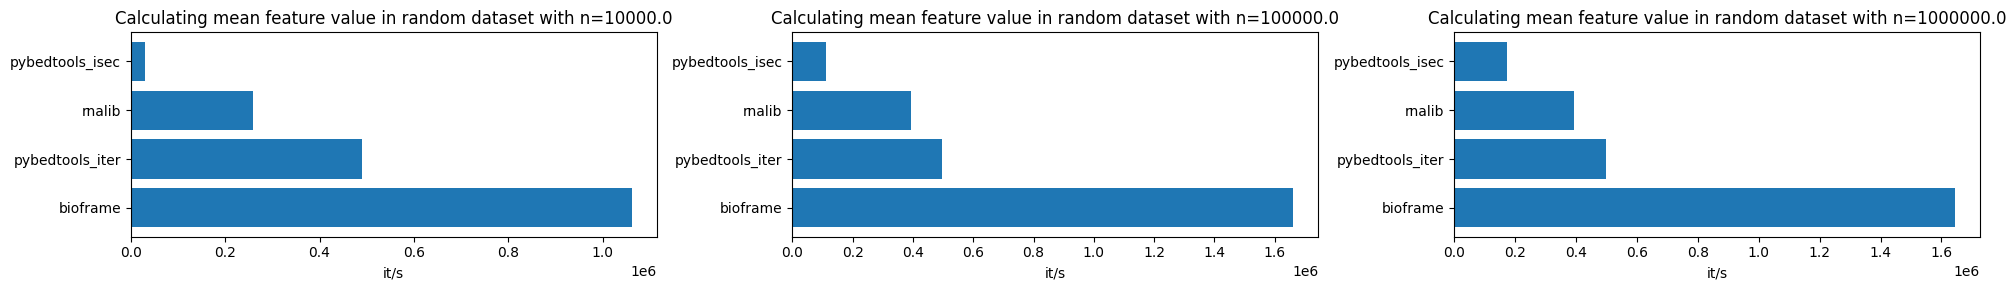

In [12]:
# from rnalib.testdata import make_random_intervals
sizes=[1e4,1e5,1e6]
chroms=['chr' + str(i + 1) for i in range(20)]
fig, axes = plt.subplots(ncols=len(sizes), squeeze=True)
stats=Counter()
for n,ax in zip(sizes,axes):
    with tempfile.TemporaryDirectory() as tempdirname:
        dataset='random dataset'
        bed_file=f'{tempdirname}/data.bedgraph'
        # create testdata
        rna.testdata.make_random_intervals(n=n, chroms=chroms).to_csv(bed_file, sep='\t', encoding='utf-8', index=False, header=False)
        rna.bgzip_and_tabix(bed_file)
        bed_file+='.gz'
        times, data, stats=Counter(),Counter(),Counter()        
        # rnalib
        with rna.Timer(times, 'rnalib') as timer:
            data[timer.name] = {}
            for chrom in chroms:
                with rna.BedGraphIterator(bed_file, chromosome=chrom) as it:
                    data[timer.name][chrom]=np.mean([v for _,v in it])
                    stats.update(it.stats)
        # pybedtools - iterate
        with rna.Timer(times, 'pybedtools_iter') as timer:
            data[timer.name] = {}
            d, s = Counter(), Counter()
            for x in pybedtools.BedTool(bed_file):
                s[x.chrom]+=float(x.name)
                d[x.chrom]+=1
            for chrom in chroms:
                data[timer.name][chrom] = s[chrom]/d[chrom]
        # pybedtools - intersect
        with rna.Timer(times, 'pybedtools_isec') as timer:
            data[timer.name] = {}
            for chrom in chroms:
                data[timer.name][chrom] = np.mean([float(x.name) for x in pybedtools.BedTool(bed_file).intersect([gi(chrom).to_pybedtools()], u=True)])
        # bioframe
        with rna.Timer(times, 'bioframe') as timer:
            with rna.BioframeIterator(bed_file) as it:
                data[timer.name] = it.df.groupby('chrom')['name'].mean().to_dict()
        # assert that results match
        for c in chroms:
            assert rna.check_list([data[x][c] for x in data.keys()], 'eq'),\
                f"Error on chrom {c}!"
        # plot the results
        rna.plot_times(f"Calculating mean feature value in {dataset} with n={n}",
                   times, n=np.sum([stats['yielded_items',c] for c in chroms]),
                   reference_method='rnalibr',
                   ax=ax)
plt.tight_layout()
plt.show()

### Value-filtered iteration
Here we compare various methods for iterating a bed file and filtering for entries with a given minimum length.

We compare bioframe with native pybedtools iterators and various filter options with rnalib's BedIterator and the wrapped PybedtoolsIterator.
We also include one approach in which we first filter via pybedtools, save the file and then iterate via a PybedtoolsIterator (pybedtools+rnalib_pybedtoolsiterator).

In this scenario, no pre-filtering based on genomic location is possible and bioframe outperforms the other methods.


WARN: Could not create refdict, is file bgzipped+tabixed? 'str' object has no attribute 'close'
Filtered BED to create /var/folders/kp/q945z6v94jl3myn35wzsl5n00000gp/T/pybedtools.e3rm7tua.tmp


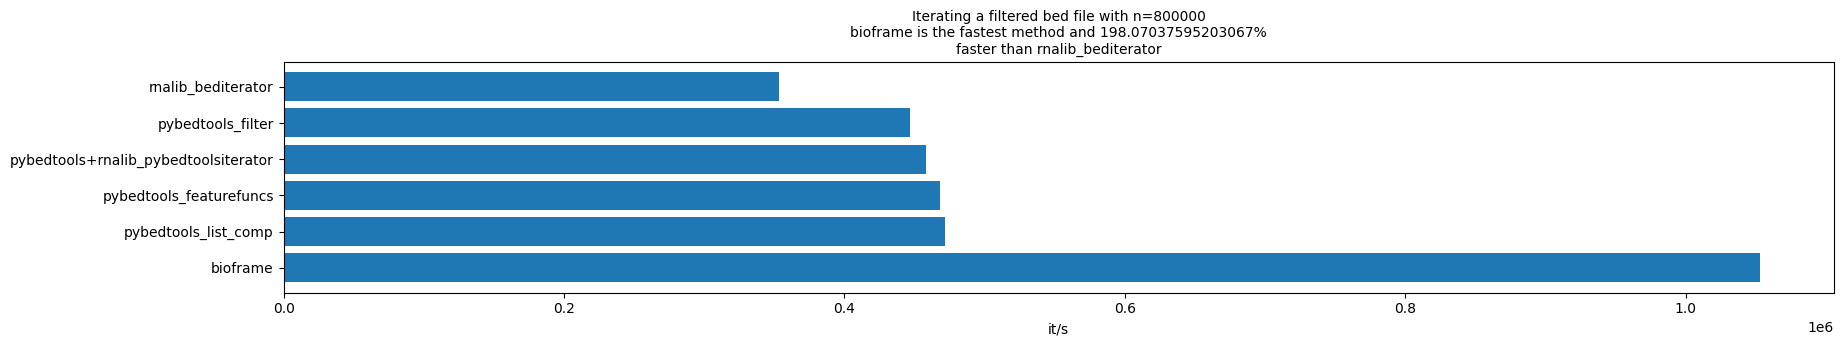

In [6]:
from pybedtools.featurefuncs import greater_than
bed_file = rna.get_resource('pybedtools_snps')  
stats,times,data=Counter(),Counter(),Counter()
minlen = 5
with rna.Timer(times, 'pybedtools_filter') as timer:
    # BedTools with filter()
    data[timer.name] = [x.name for x in pybedtools.BedTool(bed_file).filter(lambda x: len(x) > minlen)]
with rna.Timer(times, 'pybedtools_list_comp') as timer:
    # BedTools with list comprehension
    data[timer.name] = [x.name for x in pybedtools.BedTool(bed_file) if len(x) > minlen]
with rna.Timer(times, 'pybedtools_featurefuncs') as timer:
    # BedTools with filter()/featurefuncs
    data[timer.name] = [x.name for x in pybedtools.BedTool(bed_file).filter(greater_than, minlen)]
with rna.Timer(times, 'rnalib_bediterator') as timer:
    # native rnalib iterator. Collect stats from here
    with rna.BedIterator(bed_file) as it:
        data[timer.name] = [snp.data.name for snp in it if len(snp)>minlen]
        stats=it.stats # we also get some stats here...
with rna.Timer(times, 'pybedtools+rnalib_pybedtoolsiterator') as timer:
    # here we first filter via pybedtools, save the file and then iterate via a PybedtoolsIterator
    bt=pybedtools.BedTool(bed_file).filter(greater_than, minlen).saveas()
    with rna.PybedtoolsIterator(bt) as it:
        print(f"Filtered BED to create {bt.fn}")
        data[timer.name] = [snp.data.name for snp in it]
with rna.Timer(times, 'bioframe') as timer:
    with rna.BioframeIterator(rna.get_resource('pybedtools_snps')) as it:
        data[timer.name] = it.df.query(f"end-start>{minlen}")['name'].to_list()   

# check results
assert len({len(y) for y in data.values()})==1, f"Error in some computation: {data}"

# calc speed improvement
n = stats[('yielded_items', None)]
rna.plot_times(f"Iterating a filtered bed file with n={n}",
           times, n,
           reference_method='rnalib_bediterator')

### Location-filtered iteration
Here we add some more filtering steps and compare different methods for counting minus strand features on one chromosome in a large GFF3 file that is downloaded from gencode to a temporary directory, sorted, bgzipped, index and then analysed. We restrict this analysis to one chromosome only.

- for pybedtools, we either intersect the file with the respective region of interest or apply a filter method, then parse the respective fields and count
- for bioframe, we init a filtered DataFrame via our BioframeIterator implementation, filter for the proper strand and region using pandas and then iterate+count
- we use a chromosome-filtered rnalib GFF3Iterator for comparison, filter by interval strand and count the returned feature_type 

Results:
- The pybedtools_filter option is slowest as it needs to iterate the whole dataset when filtering.
- The shown pandas/bioframe approach is also relatively slow as it needs to read the whole dataframe before filtering in two steps for the targeted genomic region and strand. 
- The pybedtools_intersect option is much faster but also dominated by the intersect (chrom filtering) operation.
- Finally, the rnalib GFF3Iterator (based on pysam) is the fastest option due to the fast chromosome filtering based on the leveraged tabix index.

INFO: filtering dataframe for region chr21:0-2147483647


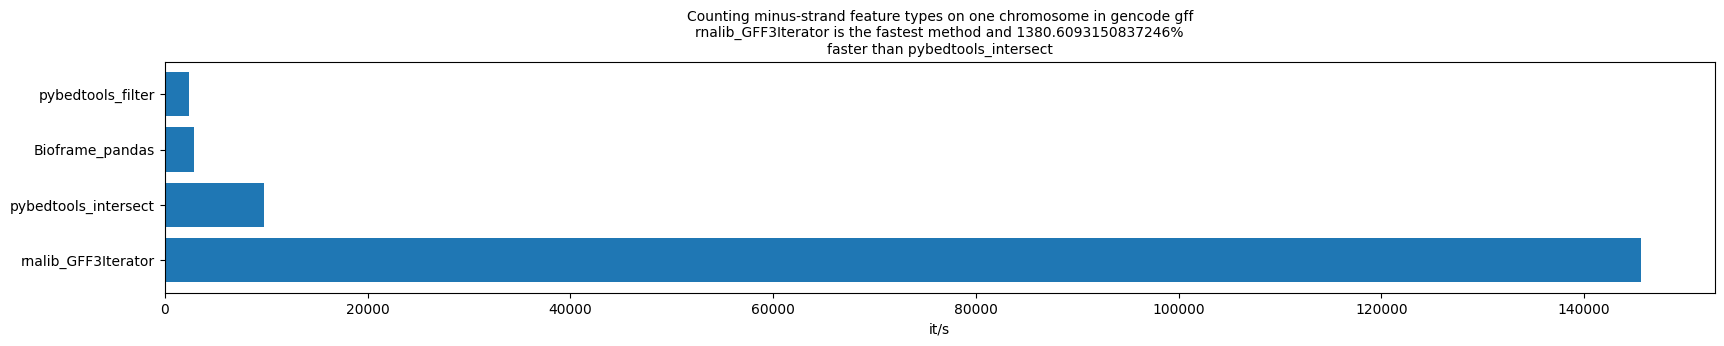

In [13]:
gff_file=rna.get_resource("full_gencode_gff")
roi=gi('chr21') # count on one chromosome only
times, data=Counter(),Counter()
with rna.Timer(times, 'pybedtools_filter') as timer:
    data[timer.name]=Counter()
    # Alternatively we could use BedTools with list comprehension or with filter()/featurefuncs
    for x in pybedtools.BedTool(gff_file).filter(lambda b: b.chrom == roi.chromosome and b.strand=='-'):
        feature_type = x.fields[2]
        data[timer.name][feature_type]+=1
        data[timer.name]['-']+=1
with rna.Timer(times, 'pybedtools_intersect') as timer:
    data[timer.name]=Counter()
    for x in pybedtools.BedTool(gff_file).intersect([roi.to_pybedtools()], u=True):
        strand, feature_type = x.strand, x.fields[2]
        if strand == '-':
            data[timer.name][feature_type]+=1
            data[timer.name][strand]+=1
with rna.Timer(times, 'rnalib_GFF3Iterator') as timer:
    data[timer.name]=Counter()
    with rna.GFF3Iterator(gff_file, region=roi) as it:
        for loc, info in it: # now iterate the values
            if loc.strand=='-':
                data[timer.name][info['feature_type']]+=1
                data[timer.name][loc.strand]+=1
        stats=it.stats      
with rna.Timer(times, 'Bioframe_pandas') as timer:
    with rna.BioframeIterator(gff_file, region=roi) as it: # init filtered dataframe
        it.df = it.df.query("strand=='-'") # further filter the dataframe with pandas
        data[timer.name]=Counter(it.df['strand'])
        data[timer.name].update(Counter(it.df['feature']))

# check results and assert that they match
res=None
for k in times.keys():
    if res is None:
        res = data[k]
    else:
        assert data[k] == res

# plot the timings
rna.plot_times(f"Counting minus-strand feature types on one chromosome in gencode gff",
           times, n=stats[('yielded_items', roi.chromosome)],
           reference_method='rnalib_GFF3Iterator')    

### Summary

While rnalib is slower than the compared approaches when a whole dataset is considered, it vastly outperforms them when only a subregion of the dataset needs to be iterated due to its efficient random access features that are built on pysam's functionality.

Please note that iteration performance was no design goal of rnalib. This performance comparison should solely demonstrate 
where our implementation standas wrt. other libraries and highlight its benefits when random access is needed.

## Potential pitfalls

In this section we demonstrate common pitfalls that regularly hamper bioinformatics analyses leading to wrong results: 
- [unsorted input files](#Pybedtools-unsorted-input-example)
- [wrongly interpreted coordinate systems](#bioframe-coordinate-mixup-example)
- [mutable interval implementations](#Mutable-interval-pitfalls)

We showcase those problems below using realistic scenarios.
Notably, in most cases *analyses run through and deliver plausible (yet wrong) results* which makes these kinds of errors hard to catch.

### Pybedtools unsorted input example

Here, we demonstrate how unsorted input may lead to wrong analysis results using pybedtools.

The following code block was copy-pasted from the [pybedtools page](https://github.com/daler/pybedtools) and the idea of this example is to create a list of gene names that are <5 kb away from intergenic SNPs. However, this code does not work properly (with pybedtools v0.9.1) due to inconsistent chromosome order of the two input files (hg19.gff: chr1, chr21; snps.bed.gz: chr21, chr1; both are pybedtools test resources).

As a result, genes.closest reports only -1 as distance which is why all closes genes will be reported, not just the ones at max 5kb distance.
Notably, the code runs without errors/warnings and returns a reasonable-sized list of gene names which makes it hard to spot the error. 
Only when omitting the `stream=True` flag, genes.closest() fails and reports the inconsistent chrom order. 

Note, that in *rnalib*, input files have to be bgzipped and indexed which requires them to be coordinate sorted and that reference dictionaries are used to ensure consistent chromosome ordering.

In [6]:
def run_pybedtools_example(gff_file, snp_file):
    snps = pybedtools.BedTool(snp_file)  
    genes = pybedtools.BedTool(gff_file)
    intergenic_snps = snps.subtract(genes).saveas()                      
    nearby = genes.closest(intergenic_snps, d=True, stream=True).saveas() 
    nbgenes = [gene.name for gene in nearby if int(gene[-1]) < 5000]
    display(f"We found {len(nbgenes)} nearby genes. Unique names: {len(set(nbgenes))}")


display("Unsorted input files:")
run_pybedtools_example(rna.get_resource("pybedtools::hg19.gff"), rna.get_resource("pybedtools::snps.bed.gz"))
display("Sorted input files:")
run_pybedtools_example(rna.get_resource("pybedtools_gff"), rna.get_resource("pybedtools_snps"))

'Unsorted input files:'

'We found 4217 nearby genes. Unique names: 4215'

'Sorted input files:'

'We found 2422 nearby genes. Unique names: 2419'

### Bioframe coordinate mixup example

In bioframe, interval coordinates are "[... assumed to be 0-based and intervals half-open (1-based ends) i.e. (start, end)](https://bioframe.readthedocs.io/en/latest/guide-definitions.html#definitions)" as, for example, in the BED file format.
However, this is not enforced or validated when reading genomic datasets in different formats (e.g., GFF) which results in bioframe wrongly interpreting 1-based as 0-base coordinates a demonstrated in the following snippet. 

Such errors shifts start coordinates of misinterpreted datasets by 1bp and may lead to subtle errors in downstream analyses. 
Note, that *rnalib* provides format-specific iterators that ensure proper coordinate interpretation which makes it harder (yet not impossible) to fall into this pit. 

In [7]:
# let's load a GFF file and a corresponding BED file with the bioframe.read_table() method (you can use igv to check they 
# are indeed representing the same intervals). The BED file was created with bedops gff2bed: 
# "gff2bed -d < gencode_44.ACTB+SOX2.gff3 | cut -f1-6 | bgzip > gencode_44.ACTB+SOX2.bed.gz"
bioframe_gff = bioframe.read_table(rna.get_resource("gencode_gff"), schema='gff')[['chrom','start','end', 'strand']]
bioframe_bed = bioframe.read_table(rna.get_resource("gencode_bed"), schema='bed')[['chrom','start','end', 'strand']]
assert bioframe.is_bedframe(bioframe_gff) and bioframe.is_bedframe(bioframe_bed) # assert that they are 'bedframes'

# let's compare them using pandas compare...
display('bioframe:', bioframe_gff.compare(bioframe_bed))
# so we see that the start coordinates indeed differ by one

# Now load via rnalib
rnalib_gff = pd.DataFrame([(loc.chromosome, loc.start, loc.end, loc.strand) \
                             for loc, info in rna.GFF3Iterator(rna.get_resource("gencode_gff"))],
                           columns=['chrom','start','end','strand'])
rnalib_bed = pd.DataFrame([(loc.chromosome, loc.start, loc.end, loc.strand) \
                             for loc, info in rna.BedIterator(rna.get_resource("gencode_bed"))],
                           columns=['chrom','start','end','strand'])

display('rnalib:', rnalib_gff.compare(rnalib_bed))
# no differences as expected as the iterators will convert the coordinates appropriately

'bioframe:'

start           
          self      other
0    180989762  180989761
1    180989770  180989769
2    180989770  180989769
3    180989771  180989770
4    180989773  180989772
..         ...        ...
340    5562574    5562573
341    5562574    5562573
342    5562574    5562573
343    5563714    5563713
344    5563714    5563713

[345 rows x 2 columns]

'rnalib:'

Empty DataFrame
Columns: []
Index: []

### Mutable interval pitfalls

Another, more subtle, pitfall results from how genomic intervals and their annotations are implemented in the different python libraries.
In most cases, intervals are implemented as [mutable](https://realpython.com/python-mutable-vs-immutable-types/) objects whose values can be changed at runtime.
Often these interval objects also contain associated (mutable) meta-data (such as interval names, scores, etc.). 
This, however, means that updates of intervals or associated meta-data results in changed hash values of the respective objects as shown below.
This makes them unsafe to use as keys in referencing datastructures such as dicts and can lead to unwanted side-effects. 

In *rnalib*, [genomic intervals](#Genomic-intervals) (locations) and their annotations are modeled separatedly with the former being implemented as [frozen (basically immutable) dataclasses](https://docs.python.org/3/library/dataclasses.html#frozen-instances) while the latter being stored in a dict-like datastructure that is indexed by the respective interval. The following codeblock demonstrates the different approaches.

In [8]:
display('Pybedtools intervals are mutable:')
i = pybedtools.Interval("chr1", 22, 44, strand='-') # create a pybedtools interval
i.name='A' # set a metadata attribute of this interval
cache = { i : 'interval found in cache.' } # put it in a dict
display(f"Now it's here: {cache.get(i, 'interval not found in cache!')} with hash value {i.__hash__()}")
i.name = 'B' # now we can just mutate the start coordinate, but this will change the hash value of this object
display(f"Now it isn't: {cache.get(i, 'interval not found in cache!')} with hash value {i.__hash__()}")

display(SEP, 'rnalib intervals are immutable:')
i = gi("chr1", 22, 44, strand='-') # create a rnalib interval
with pytest.raises(dataclasses.FrozenInstanceError):
    i.start = 21 # This will raise an 'FrozenInstanceError', you cannot mutate genomic intervals!
cache = { i : {'mess':'interval found in cache.', 'name':'A'} } # put it in a dict and add also the interval Name
display(f"Now it's here: {cache.get(i, 'interval not found in cache!')} with hash value {i.__hash__()}")
cache[i]['name']='B'
display(f"Now it's still here: {cache.get(i, 'interval not found in cache!')} with hash value {i.__hash__()}")

'Pybedtools intervals are mutable:'

"Now it's here: interval found in cache. with hash value 7641043220742679463"

"Now it isn't: interval found in cache. with hash value 5830617511814246391"

---

'rnalib intervals are immutable:'

"Now it's here: {'mess': 'interval found in cache.', 'name': 'A'} with hash value 2339145204396979470"

"Now it's still here: {'mess': 'interval found in cache.', 'name': 'B'} with hash value 2339145204396979470"

### Interval definition differences

Genomic interval definitions differ between the considered libraries (rnalib, pybedtools and bedframe).
Here are some differences:
- rnalib supports empty and unbounded intervals. The length of the latter is calculated from the chrom length if possible or zero otherwise.
- pybedtools makes little assertions on the parsed intervals. It is possible to provide files with start>end coordinates or empty intervals (start==end) 


In [9]:
display(f"Reported lengths for [1; 2] interval: rnalib: {len(gi('chr1', 1, 2))} pybedtools: {len(pybedtools.Interval('chr1',0,2))}") 
display(f"Reported lengths for [2; 1] interval: rnalib: {len(gi('chr1', 2, 1))} pybedtools: {len(pybedtools.Interval('chr1',2,0))}") 
display(f"Reported lengths for [1; ...] interval: rnalib: {len(gi('chr1', 1))} pybedtools: {len(gi('chr1', 1).to_pybedtools())}") 

# 3 different methods for counting the number of 'empty' intervals in the pybedtools SNP test file
display(f"Number of 'empty' intervals in pybedtools_snps (bioframe): {len(bioframe.read_table(rna.get_resource('pybedtools_snps'), schema='bed').query('start==end').index)}")
display(f"Number of 'empty' intervals in pybedtools_snps (rnalib): {len([loc for loc,_ in rna.BedIterator(rna.get_resource('pybedtools_snps')) if loc.is_empty()])}")
display(f"Number of 'empty' intervals in pybedtools_snps (pybedtools): {len(pybedtools.BedTool(rna.get_resource('pybedtools_snps')).filter(lambda x: x.start==x.end))}")

'Reported lengths for [1; 2] interval: rnalib: 2 pybedtools: 2'

'Reported lengths for [2; 1] interval: rnalib: 0 pybedtools: 4294967294'

'Reported lengths for [1; ...] interval: rnalib: 2147483647 pybedtools: 2147483647'

"Number of 'empty' intervals in pybedtools_snps (bioframe): 1564"

"Number of 'empty' intervals in pybedtools_snps (rnalib): 1564"

"Number of 'empty' intervals in pybedtools_snps (pybedtools): 1564"